# 12-05 BiLSTM을 이용한 개체명 인식(Named Entity Recognition, NER)

양방향 LSTM을 이용하여 개체명 인식기를 만든 후에 F1-score를 사용하여 모델을 평가합니다.

## 개체명 인식 데이터에 대한 이해와 전처리

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

data = pd.read_csv("ner_dataset.csv", encoding="latin1")

data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


In [5]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [6]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()
# Sentence #열에 Null 값들이 존재하고 있어 True

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [7]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))
# 데이터에는 47,959개의 문장이 있으며 문장들은 35,178개의 단어를 가지고 17개 종류의 개체명 태깅을 가짐

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [8]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [9]:
data = data.fillna(method="ffill") # Null 값을 가진 행의 바로 앞의 행의 값으로 Null 값을 채우는 작업을 수행
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [10]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [11]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [12]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [13]:
# 하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍(pair)으로 묶는 작업을 수행
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [16]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [17]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.

    # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentence, tag_info = zip(*tagged_sentence) 
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [18]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


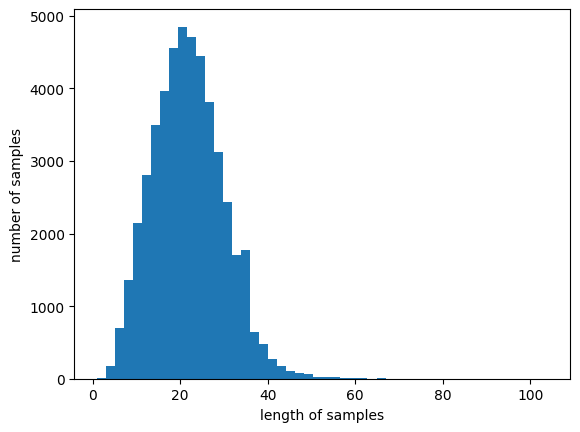

In [19]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
# 모든 단어를 사용하며 인덱스 1에는 단어 'OOV'를 할당.
src_tokenizer = Tokenizer(oov_token='OOV')
# 태깅 정보들은 내부적으로 대문자를 유지한 채 저장
tar_tokenizer = Tokenizer(lower=False)

src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

In [21]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [22]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [23]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [24]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [25]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [26]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [27]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [28]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [29]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [30]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


## 양방향 LSTM을 이용한 개체명 인식

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

Epoch 1/6
270/270 [==============================] - 693s 3s/step - loss: 0.5479 - accuracy: 0.8784 - val_loss: 0.2369 - val_accuracy: 0.9351
Epoch 2/6
270/270 [==============================] - 750s 3s/step - loss: 0.1671 - accuracy: 0.9515 - val_loss: 0.1539 - val_accuracy: 0.9543
Epoch 3/6
270/270 [==============================] - 712s 3s/step - loss: 0.1157 - accuracy: 0.9650 - val_loss: 0.1381 - val_accuracy: 0.9586
Epoch 4/6
270/270 [==============================] - 702s 3s/step - loss: 0.0941 - accuracy: 0.9707 - val_loss: 0.1371 - val_accuracy: 0.9580
Epoch 5/6
270/270 [==============================] - 712s 3s/step - loss: 0.0809 - accuracy: 0.9744 - val_loss: 0.1372 - val_accuracy: 0.9597
Epoch 6/6
270/270 [==============================] - 683s 3s/step - loss: 0.0706 - accuracy: 0.9775 - val_loss: 0.1455 - val_accuracy: 0.9581


In [32]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 4s 4s/step
단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


## F1-score

개체명 인식에서는 그 어떤 개체도 아니라는 의미의 'O'라는 태깅이 존재합니다. 그런데 이런 정보는 보통 대다수의 레이블을 차지하기 때문에 기존에 사용했던 정확도(accuracy)를 평가 방법으로 사용하는 것이 적절하지 않을 수 있습니다.  

정밀도 = TP/TP+FP  
재현율 = TP/TP+FN  
F1 SCORE = 2*(정밀도*재현율/정밀도+재현율)

In [33]:
# 예측값인 predicted가 단 1개의 개체도 맞추지 못한 상황 시뮬레이션
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['O'] * len(labels) 
print('예측값 :',predicted)
# 대부분의 값이 'O'이기 때문에 그 어떤 개체도 찾지 못하였음에도 74%의 정확도를 얻음(정확도 뻥튀기)

예측값 : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [34]:
pip install seqeval

     ---------------------------------------- 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16189 sha256=5619f4b9a72227250466fc5e10f05a049b1d0d9035d6500e603f7c387894b92c
  Stored in directory: c:\users\82105\appdata\local\pip\cache\wheels\9c\d6\00\1ccfd5a7466a94774e00022683d4b028836032dfb85007822b
Successfully built seqeval
Note: you may need to restart the kernel to use updated packages.


In [35]:
from seqeval.metrics import classification_report
print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



c:\Users\82105\anaconda3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\82105\anaconda3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## F1-score로 성능 측정하기

In [36]:
from seqeval.metrics import f1_score, classification_report

def sequences_to_tag(sequences):
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences:
        word_sequence = []
        # 시퀀스로부터 확률 벡터 또는 원-핫 벡터를 하나씩 꺼낸다.
        for pred in sequence:
            # 정수로 변환. 예를 들어 pred가 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = np.argmax(pred)            
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

300/300 [==============================] - 62s 194ms/step
F1-score: 78.0%
              precision    recall  f1-score   support

         art       0.07      0.02      0.03        63
         eve       0.58      0.29      0.38        52
         geo       0.84      0.81      0.83      7620
         gpe       0.96      0.94      0.95      3145
         nat       0.42      0.22      0.29        37
         org       0.54      0.62      0.58      4033
         per       0.72      0.71      0.72      3545
         tim       0.86      0.84      0.85      4067

   micro avg       0.78      0.78      0.78     22562
   macro avg       0.62      0.55      0.58     22562
weighted avg       0.79      0.78      0.78     22562

